<a href="https://colab.research.google.com/github/solcanalla/fiumark/blob/main/stacking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Modelo: Stacking

##Inicialización##

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

In [3]:
from sklearn.metrics import roc_curve, auc

def plot_roc(_fpr, _tpr, x):

    roc_auc = auc(_fpr, _tpr)

    plt.figure(figsize=(15, 10))
    plt.plot(
        _fpr, _tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})'
    )
    plt.scatter(_fpr, x)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()

In [4]:
!git clone https://github.com/solcanalla/fiumark.git
%cd fiumark
!git pull origin main
import preprocessing as pp

Cloning into 'fiumark'...
remote: Enumerating objects: 183, done.
remote: Counting objects: 100% (183/183), done.
remote: Compressing objects: 100% (156/156), done.
remote: Total 183 (delta 97), reused 59 (delta 26), pack-reused 0
Receiving objects: 100% (183/183), 506.02 KiB | 3.98 MiB/s, done.
Resolving deltas: 100% (97/97), done.
/content/fiumark
From https://github.com/solcanalla/fiumark
 * branch            main       -> FETCH_HEAD
Already up to date.


##Pre procesamiento##

In [5]:
pd.options.display.max_columns = None
df = pp.get_dataset()
df = pp.knn_preprocessing(df)
X_train, X_test, y_train, y_test = pp.get_train_test_data(df)

##Entrenamiento##

In [38]:
from sklearn.ensemble import StackingClassifier

clf_1 = KNeighborsClassifier(metric='minkowski',algorithm='ball_tree')
clf_2 = RandomForestClassifier(criterion='entropy')
clf_3 = XGBClassifier(max_depth= 2, min_child_weight= 2,n_estimators=55)
stacking_model = StackingClassifier(estimators=[('clf_1', clf_1), ('clf_2', clf_2),('clf_3',clf_3)])

In [39]:
from sklearn.model_selection import GridSearchCV

params = {
    'clf_2__n_estimators': np.arange(60,100,10),
    'clf_2__max_depth': np.arange(1,10,2),
    'clf_1__n_neighbors':np.arange(1,20,2),
    'clf_1__weights': ['uniform','distance'],
    'clf_1__p': np.arange(1,2)
}

gscv = GridSearchCV(
    stacking_model, params,scoring='roc_auc', n_jobs=-1, cv=5, return_train_score=True
).fit(X_train, y_train)

In [40]:
print(f"Best score: {gscv.best_score_}")
print(f"Best params {gscv.best_params_}")

Best score: 0.8660481653104279
Best params {'clf_1__n_neighbors': 11, 'clf_1__p': 1, 'clf_1__weights': 'uniform', 'clf_2__max_depth': 7, 'clf_2__n_estimators': 70}


##Evaluación del modelo##

In [41]:
y_pred = gscv.predict(X_test)

##Precision recall y F1-score###

In [42]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.82      0.93      0.87        95
         1.0       0.87      0.71      0.78        66

    accuracy                           0.84       161
   macro avg       0.85      0.82      0.83       161
weighted avg       0.84      0.84      0.84       161



###Accuracy###

In [43]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred)
accuracy

0.8385093167701864

###Auc-Roc###

In [44]:
from sklearn.metrics import roc_auc_score
auc_roc = roc_auc_score(y_test, y_pred)
auc_roc

0.8192185007974482

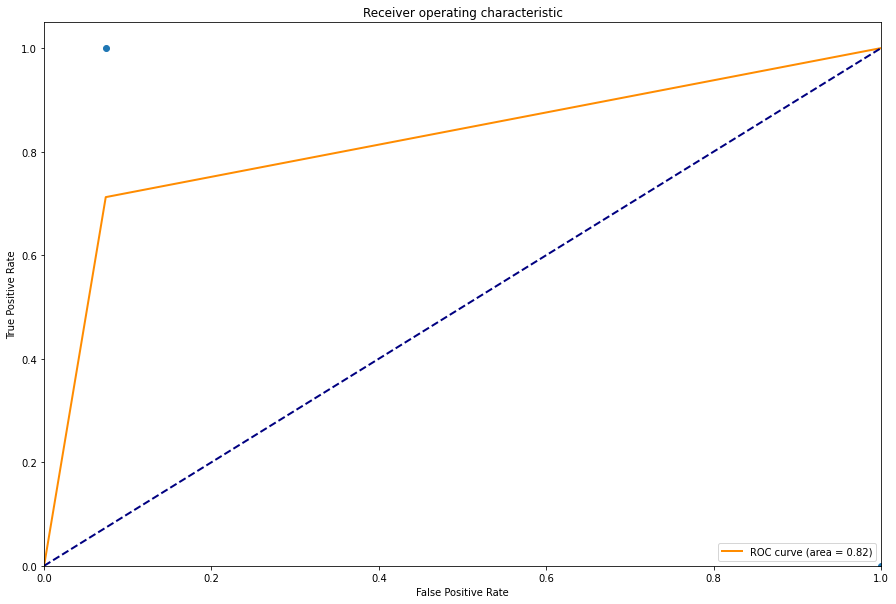

In [45]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plot_roc(fpr, tpr, thresholds)

###Matriz de confusión###

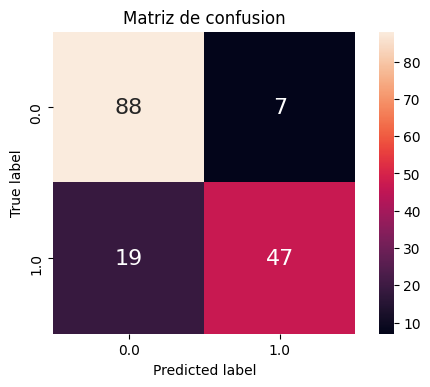

In [46]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred):
    names = sorted(set(y_true))
    cm = confusion_matrix(y_true, y_pred, names)
    df_cm = pd.DataFrame(cm, names, names)

    plt.figure(dpi=100)
    plt.title("Matriz de confusion")
    sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='g', square=True)
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.show()


plot_confusion_matrix(y_test, y_pred)

##Predicción##

In [47]:
X_holdout = pd.read_csv('https://drive.google.com/uc?export=download&id=1I980-_K9iOucJO26SG5_M8RELOQ5VB6A')
X = pp.knn_preprocessing(X_holdout)
prediction = pd.DataFrame(gscv.predict(X),columns=['volveria'],dtype=int)
pred_formatted = pd.concat([X_holdout.id_usuario,prediction],axis=1)
pred_formatted.to_csv('stacking.csv')
pred_formatted

,id_usuario,volveria
0,650,0
1,234,0
2,31,0
3,552,0
4,411,0
...,...,...
85,354,0
86,82,0
87,172,0
88,8,0
